In [1]:
import pandas as pd
import numpy as np
import  datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
dest = '/content/drive/MyDrive/Python/Chicago-Business/'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# load the data
# the data is in logs
FullDat = pd.read_csv(dest + 'FullDat-2.csv')
FullDat['Month'] = pd.to_datetime(FullDat['Month'])
FullDat['Month'] = FullDat['Month'].dt.to_period('M')
FullDat = FullDat.set_index('Month')
FullDat.index=FullDat.index.to_timestamp()
print(FullDat.shape)
print(FullDat.dtypes)

(140, 13)
Log_Count_License         float64
Log_Sum_Incentive         float64
Log_HPI                   float64
Log_Emp                   float64
Log_Elec                  float64
Log_Sum_Incentive_lag3    float64
Log_HPI_lag3              float64
Log_Emp_lag3              float64
Log_Elec_lag3             float64
Log_Sum_Incentive_lag6    float64
Log_HPI_lag6              float64
Log_Emp_lag6              float64
Log_Elec_lag6             float64
dtype: object


In [3]:
pd.DataFrame(FullDat.corr()).to_excel(dest + 'CorrMatrix.xlsx')

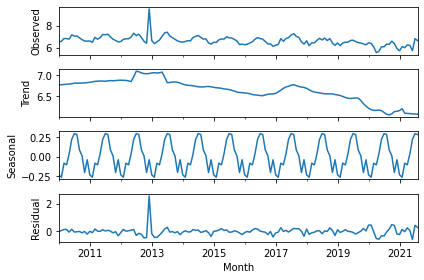

In [ ]:
# short description of the licenses variable dynamics
import matplotlib.pyplot as plt
decomposition = sm.tsa.seasonal_decompose(FullDat['Log_Count_License'], model='additive', extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

In [4]:
# spliting to train/test
FullDat = FullDat.dropna()
Train = FullDat[FullDat.index<='2019-09']
Test = FullDat[FullDat.index>'2019-09']
y_train = Train[['Log_Count_License']]
x_train = Train.drop(columns=['Log_Count_License'])
y_test = Test[['Log_Count_License']]
x_test = Test.drop(columns=['Log_Count_License'])

In [5]:
# fitting the models
LR_Mod = LinearRegression().fit(x_train,y_train)
RFR_Mod = RandomForestRegressor().fit(x_train,y_train)
XGB_Mod = xgb.XGBRegressor().fit(x_train,y_train)
SARIMAX_Mod = SARIMAX(y_train, order = (1, 1, 1), exog=x_train).fit()
SVM_Mod = SVR().fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[20:08:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# predicting outcome
forec_Mod1 = LR_Mod.predict(x_test)
forec_Mod2 = RFR_Mod.predict(x_test)
forec_Mod3 = XGB_Mod.predict(x_test)
forec_Mod4 = SARIMAX_Mod.predict(start = y_test.index[0], end = y_test.index[-1], exog=x_test)
forec_Mod4 = np.asarray(forec_Mod4)
forec_Mod5 = SVM_Mod.predict(x_test)

## LSTM - PyTorch model

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)
y_train = mm.fit_transform(y_train)
y_test = mm.fit_transform(y_test)
print('Train:', x_train.shape,y_train.shape)
print('Test:', x_test.shape,y_test.shape)

Train: (111, 12) (111, 1)
Test: (23, 12) (23, 1)


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
#- transform to tensors -#
x_train = Variable(torch.Tensor(x_train))
x_test = Variable(torch.Tensor(x_test))
y_train = Variable(torch.Tensor(y_train))
print('Train:', x_train.shape,y_train.shape)
print('Test:', x_test.shape,y_test.shape)

Train: torch.Size([111, 12]) torch.Size([111, 1])
Test: torch.Size([23, 12]) (23, 1)


In [ ]:
# reshaping to rows, timestamps, features
x_train = torch.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = torch.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print('Train:', x_train.shape,y_train.shape)
print('Test:', x_test.shape,y_test.shape)

Train: torch.Size([111, 1, 12]) torch.Size([111, 1])
Test: torch.Size([23, 1, 12]) (23, 1)


In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [ ]:
num_epochs = 1000
learning_rate = 0.001
input_size = 12 #number of features
hidden_size = 50 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, x_train.shape[1]) #our lstm class
criterion = torch.nn.MSELoss()    # Criterion of minimization (mean-squared error)
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [ ]:
# training
for epoch in range(num_epochs):
  outputs = lstm1.forward(x_train) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
  # obtain the loss function
  loss = criterion(outputs, y_train)
  loss.backward() #calculates the loss of the loss function
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.04705
Epoch: 100, loss: 0.00835
Epoch: 200, loss: 0.00065
Epoch: 300, loss: 0.00005
Epoch: 400, loss: 0.00000
Epoch: 500, loss: 0.00000
Epoch: 600, loss: 0.00000
Epoch: 700, loss: 0.00000
Epoch: 800, loss: 0.00000
Epoch: 900, loss: 0.00000


In [ ]:
# prediction
train_predict = lstm1(x_test) #forward pass
forec_Mod6 = train_predict.data.numpy() #numpy conversion
forec_Mod6 = mm.inverse_transform(forec_Mod6) #reverse transformation
y_test = mm.inverse_transform(y_test) #reverse transformation of y_test for comparison

In [ ]:
# calculate prediction metrics
Compare_Table = pd.DataFrame(columns=['Model','MAE','MSE','EVS','COD'])
ModList = ['LR','RFR','XGB','SARIMAX','SVM','LSTM']
ForecList = [forec_Mod1,forec_Mod2,forec_Mod3,forec_Mod4,forec_Mod5,forec_Mod6]
for x in range(0,6):
  mod = ForecList[x]
  ModDesc = ModList[x]
  Compare_Table = Compare_Table.append({'Model': ModDesc,
                                      'MAE':mean_absolute_error(y_test, mod),
                                      'MSE':mean_squared_error(y_test, mod),
                                      'EVS':explained_variance_score(y_test, mod),
                                      'COD':r2_score(y_test, mod)}, ignore_index=True)

In [ ]:
Compare_Table = Compare_Table.sort_values(by='MSE', ascending=False)
print(Compare_Table)

     Model       MAE       MSE        EVS        COD
3  SARIMAX  1.031634  2.259465 -11.510375 -21.102422
0       LR  0.976369  1.998707 -10.052140 -18.551653
1      RFR  0.501028  0.358206  -0.197804  -2.504024
4      SVM  0.480670  0.319286   0.024267  -2.123306
5     LSTM  0.454088  0.279176   0.216749  -1.730938
2      XGB  0.392885  0.250786  -0.478055  -1.453221


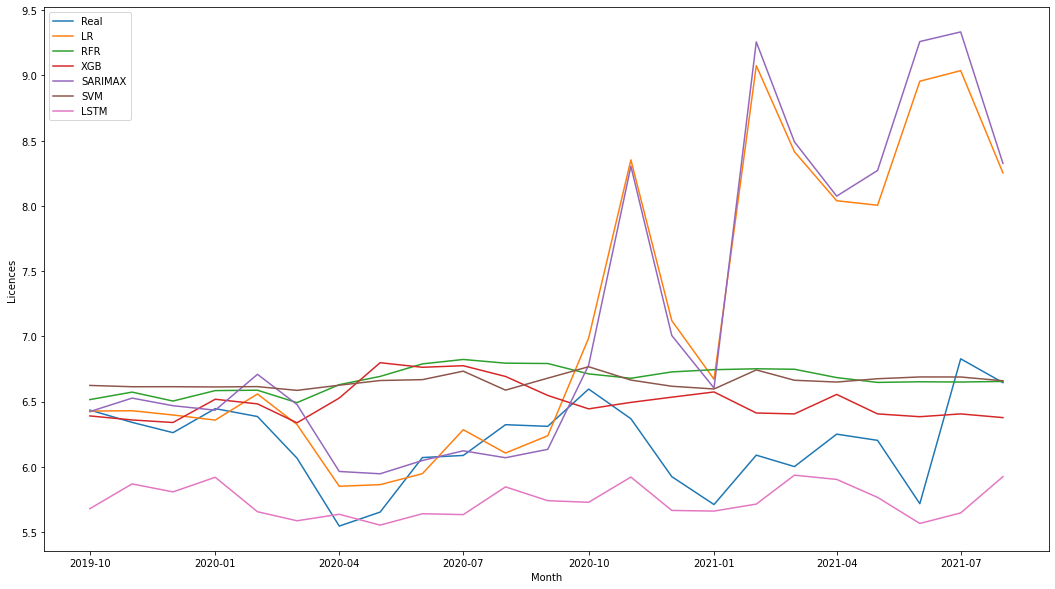

In [ ]:
# graphics
# x_axis = BaseDat[BaseDat.index>'11-1-2021']
x_axis = Test.index
plt.figure(figsize=(18, 10))
plt.plot(x_axis, y_test, label = 'Real')
plt.plot(x_axis, forec_Mod1, label = 'LR')
plt.plot(x_axis, forec_Mod2, label = 'RFR')
plt.plot(x_axis, forec_Mod3, label = 'XGB')
plt.plot(x_axis, forec_Mod4, label = 'SARIMAX')
plt.plot(x_axis, forec_Mod5, label = 'SVM')
plt.plot(x_axis, forec_Mod6, label = 'LSTM')
plt.xlabel('Month'); plt.ylabel('Licences');
plt.legend();